### Examine the Data

In [64]:
# Importing librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import statsmodels.api as sm

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [65]:

# Read the dataset
# file_name = 'valueflip_training_reduced.csv'
file_name = 'valueflip_training_reduced_new.csv'
df_raw = pd.read_csv(file_name, index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'MS'

df_raw.head()


,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,0.0,0.022568,0.0,0.0,0
0.05,0.0,0.022568,0.0,0.0,0
0.10,0.0,0.022568,0.0,0.0,0
0.15,0.0,0.022568,0.0,0.0,0
0.20,0.0,0.022568,0.0,0.0,0


In [66]:
df_raw.isna().sum()

Tank2OutFlow    0
Tank2.puddle    0
Tank3OutFlow    0
Tank2.level     0
wt3_valve       0
dtype: int64

### Plot the source data

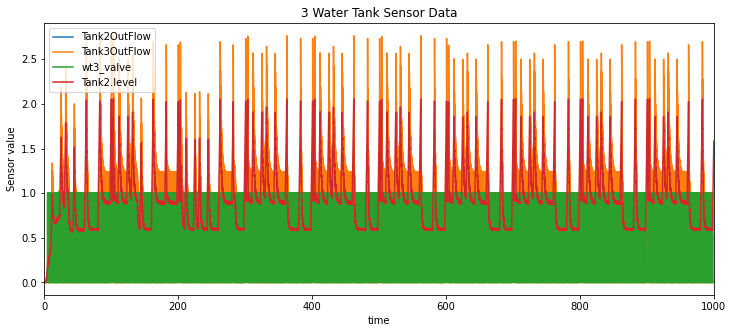

In [67]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank2OutFlow'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank3OutFlow'].plot(legend=True)
df_raw['wt3_valve'].plot(legend=True)
# df_raw['Tank2.puddle'].plot(legend=True)
df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [68]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [69]:
adf_test(df_raw['Tank2.puddle'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.161285e+01
p-value                 2.489008e-21
#lags                   4.600000e+01
#observations           1.995400e+04
critical value (1%)    -3.430678e+00
critical value (5%)    -2.861685e+00
critical value (10%)   -2.566847e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [70]:
# All the correlated features are stationary.
df_raw.head()

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,0.0,0.022568,0.0,0.0,0
0.05,0.0,0.022568,0.0,0.0,0
0.10,0.0,0.022568,0.0,0.0,0
0.15,0.0,0.022568,0.0,0.0,0
0.20,0.0,0.022568,0.0,0.0,0


### Normalisation of the dataset

In [71]:
# def normalise_timeseries(data):
#     # Calculate the mean and standard deviation for each feature
#     means = np.mean(data, axis=0)
#     stds = np.std(data, axis=0)
    
#     # Normalise each feature using standard deviation
#     normalised_data = (data - means) / stds
    
#     return pd.DataFrame(normalised_data), means, stds

In [72]:
# Read the mean and std used for normalising the golden model
var_df = pd.read_csv("norm_var_reduced.csv", index_col=0)
old_means, old_stds = var_df["0"], var_df["1"]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data = normalise_series(df_raw, old_means, old_stds)

In [73]:
df = normalised_data

In [74]:
df

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,-10.143714,-2.604337,-0.560669,-4.024580,-0.581122
0.05,-10.143714,-2.604337,-0.560669,-4.024580,-0.581122
0.10,-10.143714,-2.604337,-0.560669,-4.024580,-0.581122
0.15,-10.143714,-2.604337,-0.560669,-4.024580,-0.581122
0.20,-10.143714,-2.604337,-0.560669,-4.024580,-0.581122
...,...,...,...,...,...
999.80,0.153726,2.011939,-0.560669,0.106443,-0.581122
999.85,0.159885,2.011939,-0.560669,0.162052,-0.581122
999.90,0.191332,2.011939,-0.560669,0.245495,-0.581122


In [75]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(17001, 3000)

### VAR Model Order Selection

In [76]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 43 has the least AIC value. Let us select p = 43 in the modelling


In [77]:
# p = [1,2,3,4,5,6,7] # try with list of 7 p values
# p = list(range(1,20))
# aic, bic = [], []
# for i in p:
#     model = VAR(train)
#     results = model.fit(i)
#     aic.append(results.aic)
#     bic.append(results.bic)
#     print(f'VAR Order {i}')
#     print('AIC: {}'.format(results.aic))
#     print('BIC: {}'.format(results.bic))
#     print()

# min_aic = min(aic)
# min_aic_index = aic.index(min_aic) + 1
# min_bic = min(bic)
# min_bic_index = bic.index(min_bic) + 1
# print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


In [78]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank2OutFlow', 'Tank2.puddle', 'Tank3OutFlow', 'Tank2.level', 'wt3_valve']

In [79]:
from IPython.display import Markdown as md
md("Fit the VAR( {{}} ) model".format(min_aic_index))

Fit the VAR( {} ) model

### Fit the VAR {{min_aic_index}}  model

In [80]:
min_aic_index

43

In [81]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     18:24:00
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -49.0018
Nobs:                     16958.0    HQIC:                  -49.3321
Log likelihood:           300433.    FPE:                3.19714e-22
AIC:                     -49.4946    Det(Omega_mle):     3.00108e-22
--------------------------------------------------------------------
Results for equation Tank2OutFlow
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000931         0.000035           26.701           0.000
L1.Tank2OutFlow          1.187868         0.007340          161.843           0.000
L1.Tank2.puddle          0.272838        

### Predict the next 20 values

In [82]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

43

In [83]:
df.head()

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.05,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.10,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.15,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.20,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122


In [84]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 0.15381155,  1.64882437,  0.97543579, -1.4233358 , -0.6055155 ],
       [ 0.16917061,  1.64884261, -0.58818684, -1.34877454,  1.67588451],
       [ 0.19122104,  1.64905162,  0.9283091 , -1.42463291, -0.61477312],
       [ 0.18961816,  1.64905919, -0.59901298, -1.34826152,  1.6369664 ],
       [ 0.16849974,  1.64925138,  0.89267442, -1.42053158, -0.62827227],
       [ 0.15440841,  1.64923763, -0.61552014, -1.34209867,  1.60719508],
       [ 0.16931764,  1.64941256,  0.87163484, -1.41241978, -0.6445044 ],
       [ 0.19600754,  1.64939635, -0.62730832, -1.33253731,  1.58137602],
       [ 0.18993367,  1.64957095,  0.84958959, -1.40055852, -0.65038472],
       [ 0.15857046,  1.64955291, -0.626448  , -1.32063831,  1.55682049],
       [ 0.15456348,  1.64971961,  0.83147934, -1.38715337, -0.65923538],
       [ 0.18072817,  1.64968581, -0.63107729, -1.30672023,  1.52670597],
       [ 0.19579859,  1.649841  ,  0.81009027, -1.37120516, -0.65730378],
       [ 0.18048871,  1.6497994 , -0.6

In [85]:
test

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
850.05,0.153726,1.648839,0.974244,-1.422864,-0.581122
850.10,0.169092,1.648861,-0.560669,-1.351615,1.720809
850.15,0.191332,1.649109,0.969217,-1.431384,-0.581122
850.20,0.190050,1.649131,-0.560669,-1.359808,1.720809
850.25,0.168778,1.649378,0.964695,-1.439049,-0.581122
...,...,...,...,...,...
999.80,0.153726,2.011939,-0.560669,0.106443,-0.581122
999.85,0.159885,2.011939,-0.560669,0.162052,-0.581122
999.90,0.191332,2.011939,-0.560669,0.245495,-0.581122


In [86]:
attr = list(pd.read_csv(file_name).columns.values)[1:]
df_forecast = pd.DataFrame(z, columns=attr)
df_forecast[:5]

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
0,0.153812,1.648824,0.975436,-1.423336,-0.605515
1,0.169171,1.648843,-0.588187,-1.348775,1.675885
2,0.191221,1.649052,0.928309,-1.424633,-0.614773
3,0.189618,1.649059,-0.599013,-1.348262,1.636966
4,0.168500,1.649251,0.892674,-1.420532,-0.628272


### Plot the results

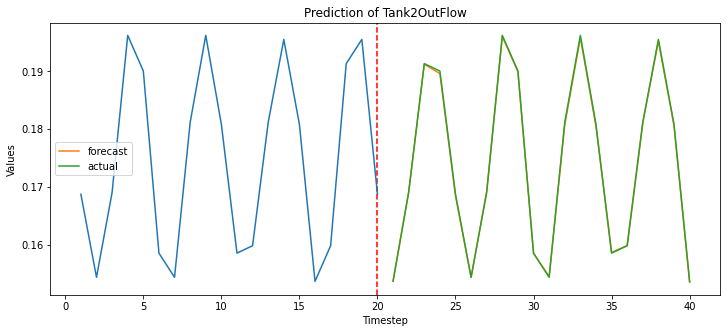

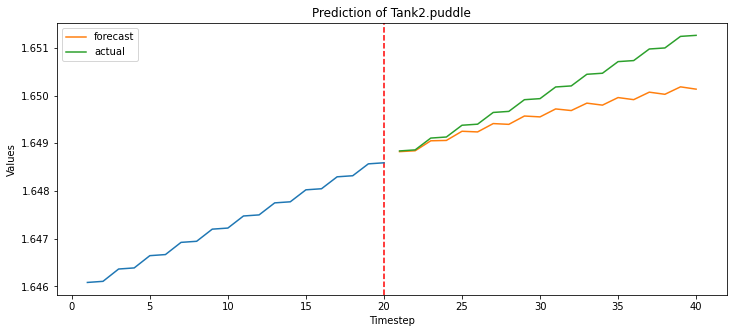

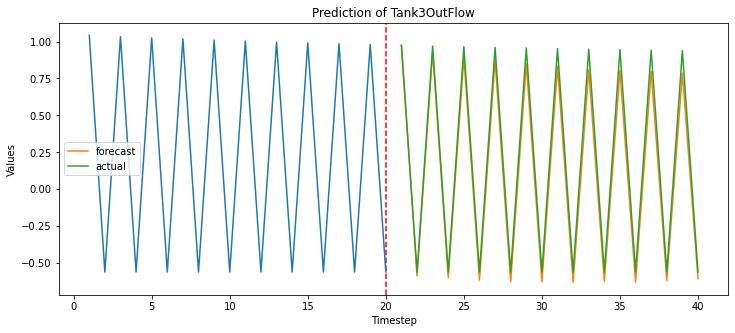

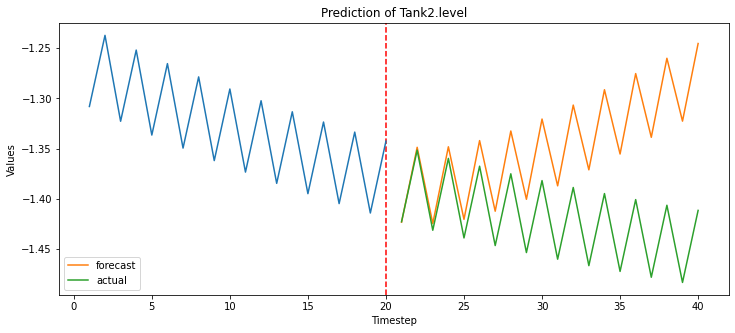

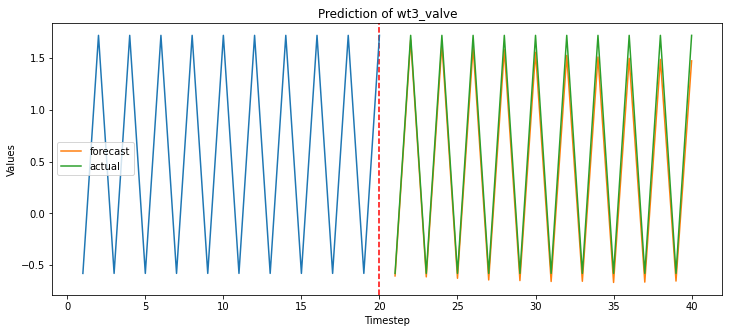

In [87]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# input_length = 20
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index = pd.Index(list(range(1, input_length+1)))
#     actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual = actual.set_index(actual_index)
#     pred = df_forecast.set_index(index)
#     actual_test = test.iloc[:lag_order+1,:].set_index(index)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual.iloc[:,i])
#     plt.plot(pred.iloc[:,i], label="forecast")
#     plt.plot(actual_test.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()
    


attr = list(pd.read_csv(file_name).columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

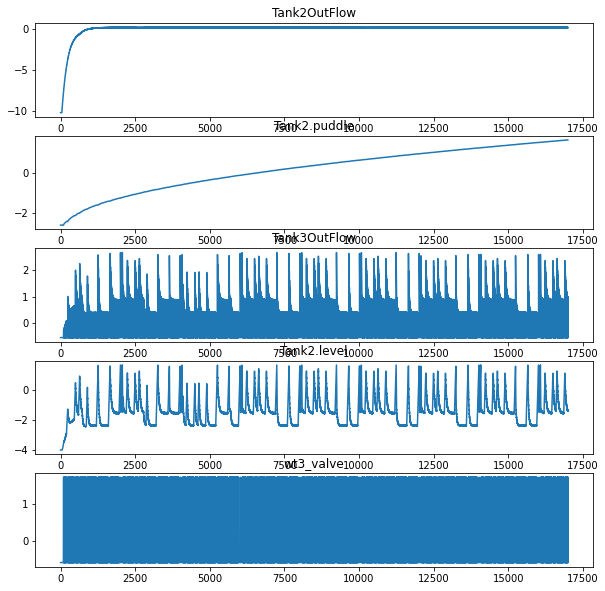

In [88]:
results.plot();

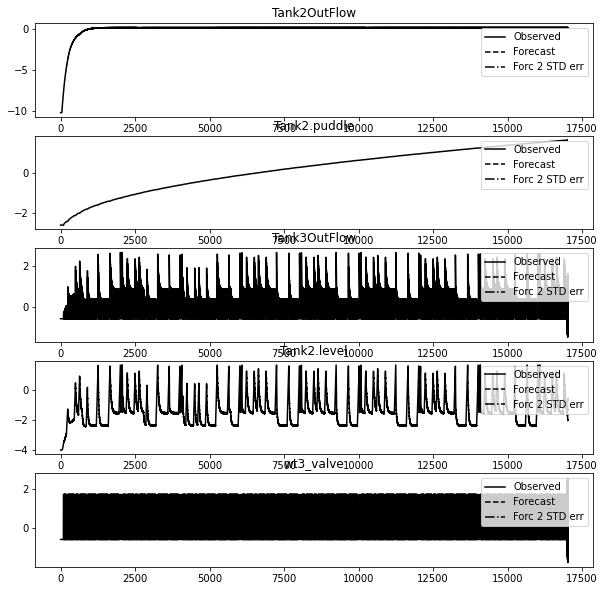

In [89]:
results.plot_forecast(20);

In [90]:
len(df_forecast)

20

In [91]:
len(df['Tank2.puddle'].iloc[:steps])

20

### Model Evaluation

In [92]:
# attr = [Tank2OutFlow', 'Tank2.puddle', 'Tank3OutFlow', 'Tank2.level', 'wt3_valve']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat].iloc[:steps], actual_test[feat]))

print(RMSE) 

[0.0002361761389282414, 0.0005970887950335464, 0.08853190931480655, 0.09119586987762623, 0.1339963400535151]


### Save the model

In [93]:
# Serialize andsave the model

with open('expert_models/var_ctrl_valueFlip_perms_reduced.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")

Model saved!


In [94]:
print(error)

NameError: name 'error' is not defined

### Define the faulty data

In [ ]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)

faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

### Load the model and reconstruct VAR

In [ ]:
with open('var_ctrl_valueFlip.pkl', 'rb') as f:
    params = pickle.load(f)
    
valueFlip_model = sm.tsa.VAR(train)
valueFlip_model.params = params
valueFlip_model_fit = valueFlip_model.fit(min_aic_index)

valueFlip_model_fit.summary()

### Forecast using faulty data

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast = valueFlip_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

In [ ]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Increasing the duration of the faults

In [ ]:
faulty_data_extend = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)

faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = valueFlip_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

In [ ]:
import keyword
print(keyword.kwlist)